In [1]:
import cv2
import numpy as np

import time
import sys
import os
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
CONFIDENCE = 0.5
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

# the neural network configuration
config_path = "cfg/yolov3.cfg"
# the YOLO net weights file
weights_path = "weights/yolov3.weights"
# weights_path = "weights/yolov3-tiny.weights"

# loading all the class labels (objects)
labels = open("data/coco.names").read().strip().split("\n")
# generating colors for each object for later plotting
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

In [3]:
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [4]:
path_name = "images/nathan-rogers-jMmv6HhHb0k-unsplash.jpg"
image = cv2.imread(path_name)
file_name = os.path.basename(path_name)
filename, ext = file_name.split(".")

In [5]:
h, w = image.shape[:2]
# create 4D blob
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

In [6]:
print("image.shape:", image.shape)
print("blob.shape:", blob.shape)

image.shape: (853, 1137, 3)
blob.shape: (1, 3, 416, 416)


In [7]:
# sets the blob as the input of the network
net.setInput(blob)
# get all the layer names
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# feed forward (inference) and get the network output
# measure how much it took in seconds
start = time.perf_counter()
layer_outputs = net.forward(ln)
time_took = time.perf_counter() - start
print(f"Time took: {time_took:.2f}s")

Time took: 0.53s


In [8]:
font_scale = 1
thickness = 1
boxes, confidences, class_ids = [], [], []
# loop over each of the layer outputs
for output in layer_outputs:
    # loop over each of the object detections
    for detection in output:
        # extract the class id (label) and confidence (as a probability) of
        # the current object detection
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        # discard out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > CONFIDENCE:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [9]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_THRESHOLD, IOU_THRESHOLD)

In [10]:
# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        x, y = boxes[i][0], boxes[i][1]
        w, h = boxes[i][2], boxes[i][3]
        # draw a bounding box rectangle and label on the image
        color = [int(c) for c in colors[class_ids[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness)
        text = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
        # calculate text width & height to draw the transparent boxes as background of the text
        (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
        text_offset_x = x
        text_offset_y = y - 5
        box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
        overlay = image.copy()
        cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
        # add opacity (transparency to the box)
        image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
        # now put the text (label: confidence %)
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=font_scale, color=(0, 0, 0), thickness=thickness)

In [11]:
cv2.imwrite(filename + "_yolo3." + ext, image)

True

In [12]:
RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

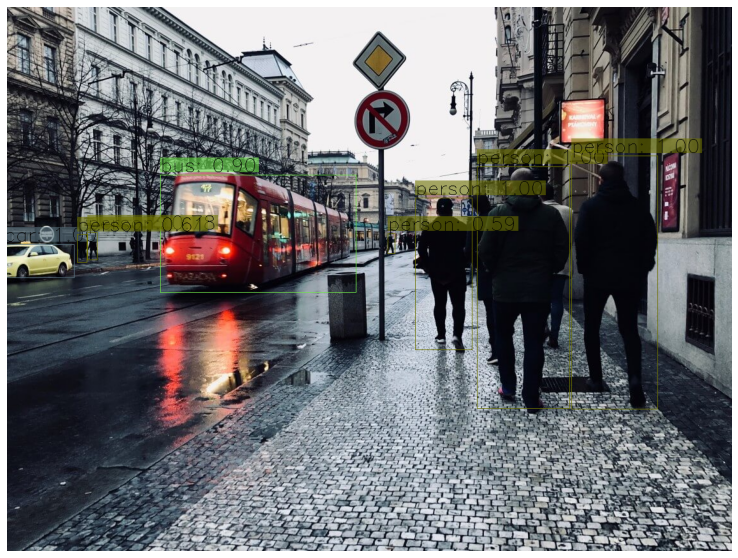

In [13]:
plt.axis('off')
plt.imshow(RGB_im)

In [14]:
labels

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']